In [1]:
!pip install torchvision
!pip install ipython

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 7.0 MB/s eta 0:00:00


In [2]:
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torchvision import datasets, transforms, models
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from PIL import Image  # Importing the PIL library for image handling

# Check if CUDA is available
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

# Load Dataset
main_folder = "/content/drive/MyDrive/unzipped/Dataset"
validation_folder = "/content/drive/MyDrive/unzipped/Data Validation"
class_names = sorted(os.listdir(main_folder))
val_class_names = sorted(os.listdir(validation_folder))

x = []  # to store image arrays
y = []  # to store labels

# Prepare Training Dataset
for folder in sorted(os.listdir(main_folder)):
    image_list = os.listdir(os.path.join(main_folder, folder))
    for img_name in image_list:
        img_path = os.path.join(main_folder, folder, img_name)
        img = Image.open(img_path).convert('RGB')  # Load image with PIL
        img = img.resize((100, 100))  # Resize image
        img = np.array(img)  # Convert to numpy array
        x.append(img)
        y.append(class_names.index(folder))

x = np.array(x)
y = np.array(y)

# Prepare Validation Dataset
val_images = []
val_image_label = []

for folder in sorted(os.listdir(validation_folder)):
    image_list = os.listdir(os.path.join(validation_folder, folder))
    for img_name in image_list:
        img_path = os.path.join(validation_folder, folder, img_name)
        img = Image.open(img_path).convert('RGB')  # Load image with PIL
        img = img.resize((100, 100))  # Resize image
        img = np.array(img)  # Convert to numpy array
        val_images.append(img)
        val_image_label.append(val_class_names.index(folder))

val_images = np.array(val_images)
val_image_label = np.array(val_image_label)

# Normalize images
x = x / 255.0
val_images = val_images / 255.0

# Split data into training and validation sets
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.2, random_state=5)

# Convert to PyTorch tensors
xtrain_tensor = torch.tensor(xtrain, dtype=torch.float32).permute(0, 3, 1, 2)  # Change to C x H x W
ytrain_tensor = torch.tensor(ytrain, dtype=torch.long)
xtest_tensor = torch.tensor(xtest, dtype=torch.float32).permute(0, 3, 1, 2)
ytest_tensor = torch.tensor(ytest, dtype=torch.long)

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
from PIL import Image

# Define image transformations
transform = transforms.Compose([
    transforms.Resize((100, 100)),
    transforms.ToTensor(),
])

# Function to predict individual images
def predict(img_name):
    # Load and preprocess image
    img = Image.open(img_name).convert('RGB')
    img_tensor = transform(img).unsqueeze(0).to(device)  # Add batch dimension and move to device

    # Display the image
    plt.imshow(img)
    plt.axis('off')
    plt.show()

    # Make prediction
    model.eval()
    with torch.no_grad():
        prediction = model(img_tensor)
    output = torch.argmax(prediction, dim=1).item()

    print("Predicted class:", class_names[output])

# Function to plot an image with prediction details
def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img.transpose(1, 2, 0))  # Change to H x W x C for display

    predicted_label = np.argmax(predictions_array)
    true_label = np.argmax(true_label)

    color = 'green' if predicted_label == true_label else 'red'
    plt.xlabel("{}: {:.2f}% ({})".format(
        val_class_names[predicted_label],
        100 * np.max(predictions_array),
        val_class_names[true_label]), color=color)

# Function to plot the value array as a bar chart
def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array[i], true_label[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    predicted_label = np.argmax(predictions_array)
    true_label = np.argmax(true_label)

    thisplot = plt.bar(range(len(class_names)), predictions_array, color='seashell')
    plt.ylim([0, 1])

    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('green')

In [ ]:
# # Step 1: Mount Google Drive
# from google.colab import drive
# drive.mount('/content/drive')

# # Step 2: Specify the path to the zip file and the extraction directory
# zip_file_path = '/content/drive/MyDrive/waste_z.zip'  # Update with your file path
# extraction_path = '/content/drive/MyDrive/unzipped'   # Update with your desired extraction path

# # Step 3: Unzip the folder
# import zipfile
# import os

# # Create the extraction directory if it doesn't exist
# os.makedirs(extraction_path, exist_ok=True)

# # Unzip the file
# with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
#     zip_ref.extractall(extraction_path)

# print("Unzipping completed!")

In [4]:
import torch
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from torchvision.models import resnet50, ResNet50_Weights
import numpy as np
from PIL import Image
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn as nn
import torch.optim as optim

# Define image transformations for data augmentation
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.Resize((100, 100)),
    transforms.ToTensor(),
])

val_transform = transforms.Compose([
    transforms.Resize((100, 100)),
    transforms.ToTensor(),
])

class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img = self.images[idx]
        label = self.labels[idx]

        # Ensure img is in the correct format
        if isinstance(img, np.ndarray):
            img = Image.fromarray((img * 255).astype(np.uint8))  # Convert normalized array to image
        elif isinstance(img, torch.Tensor):
            img = transforms.ToPILImage()(img)  # Convert tensor back to PIL Image if needed

        if self.transform:
            img = self.transform(img)  # Apply transformations

        return img, label

# Create datasets
train_dataset = CustomDataset(xtrain_tensor, ytrain_tensor, transform=train_transform)
val_dataset = CustomDataset(xtest_tensor, ytest_tensor, transform=val_transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)

# Load ResNet50 Model
model = resnet50(weights=ResNet50_Weights.DEFAULT)
model.fc = nn.Linear(model.fc.in_features, len(class_names))
model.to(device)

# Define Loss, Optimizer, and Scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.1)

# Early Stopping parameters
patience = 10
best_loss = float('inf')
patience_counter = 0
best_model_path = "best_model.pth"

# Training Loop
epochs = 25
for epoch in range(epochs):
    model.train()
    total_loss = 0

    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)

        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f'Epoch {epoch + 1}/{epochs}, Training Loss: {avg_loss}')

    # Validation Phase
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_x, batch_y in val_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct += (predicted == batch_y).sum().item()
            total += batch_y.size(0)

    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = correct / total * 100
    print(f'Validation Loss: {avg_val_loss}, Validation Accuracy: {val_accuracy:.2f}%')

    # Learning rate scheduling
    scheduler.step(avg_val_loss)

    # Check for early stopping
    if avg_val_loss < best_loss:
        best_loss = avg_val_loss
        patience_counter = 0
        torch.save(model.state_dict(), best_model_path)  # Save the best model
        print(f"Best model saved with loss: {best_loss:.4f}")
    else:
        patience_counter += 1
        print(f"Patience counter: {patience_counter}/{patience}")

    if patience_counter >= patience:
        print("Early stopping triggered.")
        break

print("Training completed.")

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 159MB/s]


Epoch 1/25, Training Loss: 0.9441190322240194
Validation Loss: 6.665863037109375, Validation Accuracy: 40.44%
Best model saved with loss: 6.6659
Epoch 2/25, Training Loss: 0.555136130253474
Validation Loss: 0.7818641513586044, Validation Accuracy: 80.22%
Best model saved with loss: 0.7819
Epoch 3/25, Training Loss: 0.4324849466482798
Validation Loss: 0.8776886016130447, Validation Accuracy: 78.02%
Patience counter: 1/10
Epoch 4/25, Training Loss: 0.2770753353834152
Validation Loss: 0.5277990698814392, Validation Accuracy: 81.98%
Best model saved with loss: 0.5278
Epoch 5/25, Training Loss: 0.22389295995235442
Validation Loss: 0.801517903804779, Validation Accuracy: 73.41%
Patience counter: 1/10
Epoch 6/25, Training Loss: 0.18375220547119778
Validation Loss: 1.05262890458107, Validation Accuracy: 72.09%
Patience counter: 2/10
Epoch 7/25, Training Loss: 0.18949715743462245
Validation Loss: 0.5072983801364899, Validation Accuracy: 84.84%
Best model saved with loss: 0.5073
Epoch 8/25, Trai

Validation Loss: 0.3745168671011925, Validation Accuracy: 92.53%
Number of predictions: 455
Number of images in val_image_label: 256
Number of images in xtest_tensor: 455


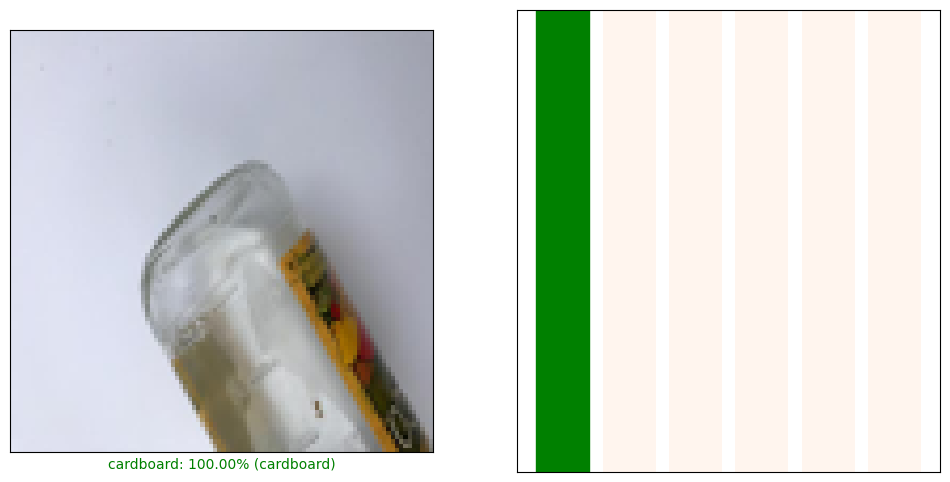

In [7]:
predictions = []

model.eval()
val_loss = 0
correct = 0
total = 0

with torch.no_grad():
    for batch_x, batch_y in val_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        val_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == batch_y).sum().item()
        total += batch_y.size(0)

        # Append predictions
        predictions.extend(predicted.cpu().numpy())  # Make sure to move predictions to CPU and convert to numpy array

avg_val_loss = val_loss / len(val_loader)
val_accuracy = correct / total * 100  # Calculate accuracy as a percentage
print(f'Validation Loss: {avg_val_loss}, Validation Accuracy: {val_accuracy:.2f}%')

# Check sizes before plotting
print(f"Number of predictions: {len(predictions)}")
print(f"Number of images in val_image_label: {len(val_image_label)}")
print(f"Number of images in xtest_tensor: {len(xtest_tensor)}")

# Ensure index is valid
i = 29  # Check if i is within bounds of the arrays
if i >= len(predictions) or i >= len(val_image_label) or i >= len(xtest_tensor):
    print(f"Index {i} is out of range. Please choose an index between 0 and {min(len(predictions), len(val_image_label), len(xtest_tensor)) - 1}.")
else:
    # Plotting example image
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plot_image(i, predictions, val_image_label, xtest_tensor.cpu().numpy())
    plt.subplot(1, 2, 2)
    plot_value_array(i, predictions, val_image_label)
    plt.show()


In [8]:
torch.save(model.state_dict(),'/content/drive/MyDrive/my_model.pth')

In [10]:
import torch
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Prepare prediction and label arrays for calculating metrics
all_labels = []
all_predictions = []

model.eval()
val_loss = 0
correct = 0
total = 0

with torch.no_grad():
    for batch_x, batch_y in val_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        val_loss += loss.item()

        # Predictions
        _, predicted = torch.max(outputs, 1)

        # Accumulate predictions and labels for calculating metrics later
        all_predictions.extend(predicted.cpu().numpy())  # Move predictions to CPU and extend the list
        all_labels.extend(batch_y.cpu().numpy())  # Move labels to CPU and extend the list

        # Calculate accuracy for the batch
        correct += (predicted == batch_y).sum().item()
        total += batch_y.size(0)

# Calculate average validation loss
avg_val_loss = val_loss / len(val_loader)

# Convert accumulated predictions and labels to numpy arrays
all_predictions = torch.tensor(all_predictions)
all_labels = torch.tensor(all_labels)

# Calculate Accuracy
val_accuracy = accuracy_score(all_labels, all_predictions) * 100  # Percentage

# Calculate Precision, Recall, F1-Score (for each class)
precision = precision_score(all_labels, all_predictions, average='weighted')
recall = recall_score(all_labels, all_predictions, average='weighted')
f1 = f1_score(all_labels, all_predictions, average='weighted')

# Print metrics
print(f'Validation Loss: {avg_val_loss:.4f}')
print(f'Validation Accuracy: {val_accuracy:.2f}%')
print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}')


Validation Loss: 0.3745
Validation Accuracy: 92.53%
Precision: 0.9266, Recall: 0.9253, F1 Score: 0.9251


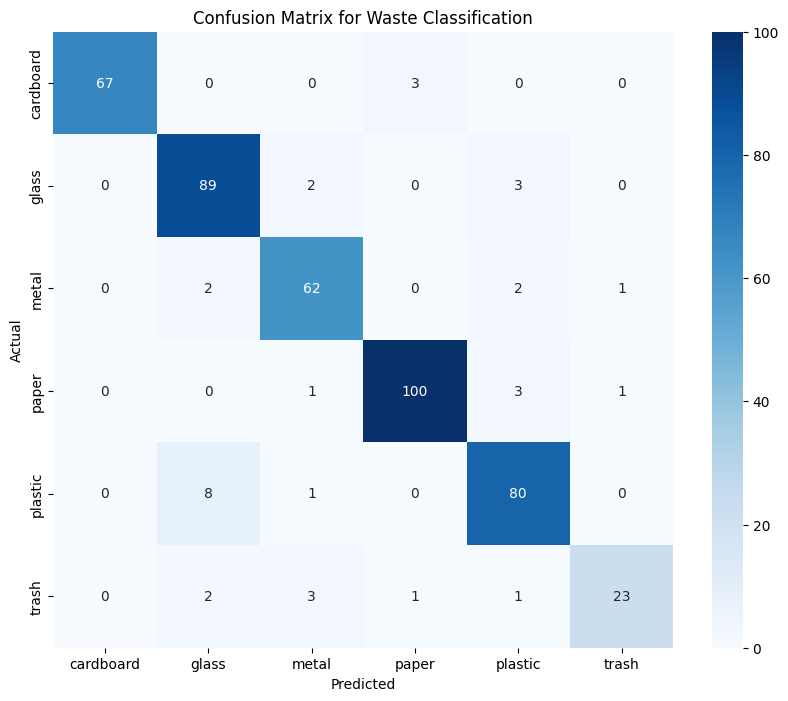

In [9]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Store true labels and predicted labels
y_true = []
y_pred = []

model.eval()
with torch.no_grad():
    for batch_x, batch_y in val_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        outputs = model(batch_x)

        # Get the predicted labels
        _, predicted = torch.max(outputs, 1)

        # Append true and predicted labels
        y_true.extend(batch_y.cpu().numpy())  # Convert tensors to numpy arrays
        y_pred.extend(predicted.cpu().numpy())

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plotting the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix for Waste Classification')
plt.show()
